# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. Now we download required files and create an environment.

In [2]:
!rm ddpg_agent.py model.py
!curl https://raw.githubusercontent.com/VVKot/deep-reinforcement-learning/master/p3_collab-compet/ddpg_agent.py --output ddpg_agent.py
!curl https://raw.githubusercontent.com/VVKot/deep-reinforcement-learning/master/p3_collab-compet/model.py --output model.py
!curl https://raw.githubusercontent.com/VVKot/deep-reinforcement-learning/master/p2_continuous-control/workspace_utils.py --output workspace_utils.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8026  100  8026    0     0  49530      0 --:--:-- --:--:-- --:--:-- 54598
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2974  100  2974    0     0  22560      0 --:--:-- --:--:-- --:--:-- 22876
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1549  100  1549    0     0  11865      0 --:--:-- --:--:-- --:--:-- 12101


In [3]:
import numpy as np
import torch
from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment
from workspace_utils import active_session

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
print(brain)

TennisBrain
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
# for i in range(5):                                         # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [7]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

Now we can instantiate two agents to play tennis. We make the code more general since potentially the same approach might be applied for the environment with more than two agents.

In [8]:
env_info = env.reset(train_mode=True)[brain_name]

def create_agent(states, actions):
    return Agent(states, actions, 0)

agents = [create_agent(state_size, action_size) for _ in range(num_agents)] # create two agents to play tennis

A separate agent is created for both players.

The agent is represented by two neural networks - Actor and Critic. Both of them are of equal size, with 512 neurons in each layer, and 4 layers. Network with 3 layers in my experience wasn't sufficient to achieve the task. Inner layers of both networks have leaky RELU activation function - in my experiments, it helped to converge faster compared to RELU/ELU. Since Actor has to produce values for actions, and we operate in continuos space where each action has to be a value from -1 to 1, is has a tanh activation function at the last layer. On the other hand, Critic produces Q values, that's why it does not have an activation function for the last layer at all. Both networks are trained using Adam optimizer. The choice of action is not greedy. Since we cannot use epsilon-greedy policy in continuous space, every action is changed slightly using Ornstein-Uhlenbeck noise.

Learning is stabilized by using fixed Q-targets and soft updates.

When evaluating the default model and agent from DDPG lesson versus the model and agent that I've used to solve P2, I found my implementation is more robust and is able to learn faster. I think the primary reason for that is the increased size of the network, using which agent can quickly learn more complex interaction - e.g. moving AND jumping. The parameter that had the most influence on the speed of the learning and convergence was the learning rate. After several unsuccessful options(from 10^-5 to 10^-3) I found a feasible option at 8\*10^-5, using which need average score was achieved after 1000 episodes.

In [9]:
from collections import deque
import torch
from workspace_utils import active_session

def ddpg(n_episodes=10000,print_every=100):
    env_info = env.reset(train_mode=True)[brain_name]
    for agent in agents: # do not forget to reset all agents
        agent.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        for agent in agents:
            agent.reset() # reset every agent for each episode
        states = env_info.vector_observations
        score = np.zeros(num_agents) # score should be represented as an array due to presence of multiple agents
        num_step = 0
        while True:
            actions = np.stack(agent.act(state) for agent, state in zip(agents, states))
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            for agent, s, a, r, n, d in zip(agents, states, actions, rewards, next_states, dones):
                agent.step(s, a, r, n, d) # act with every agent
            states = next_states # move all agents to next states
            score += np.array(rewards) # update scores
            num_step += 1 # move to next iteration
            if any(dones):
                break # if episode was finished due to dropping the ball - break and record score
        print('\rEpisode {}\tReward: {:.2f}'.format(i_episode, np.sum(rewards)), end="")
        scores_deque.append(np.max(score)) # get the maximum score of all agents
        scores.append(np.max(score)) # record this score
        for i, agent in enumerate(agents):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{:02d}.pth'.format(i))
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_{:02d}.pth'.format(i))
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tmax_step:{}'.format(i_episode, np.mean(scores_deque), num_step))
            if np.mean(scores_deque) >= 0.5:
                print("Score is higher than 0.5")
                break
    return scores

with active_session(): # used to avoid workspace restart due to long-running learning process
    scores = ddpg()

Episode 100	Average Score: 0.00	max_step:14
Episode 200	Average Score: 0.02	max_step:14
Episode 300	Average Score: 0.05	max_step:17
Episode 400	Average Score: 0.05	max_step:15
Episode 500	Average Score: 0.06	max_step:30
Episode 600	Average Score: 0.07	max_step:60
Episode 700	Average Score: 0.11	max_step:14
Episode 800	Average Score: 0.21	max_step:30
Episode 900	Average Score: 0.32	max_step:71
Episode 1000	Average Score: 0.76	max_step:29
Score is higher than 0.5


Now we can visualize results of the agent:

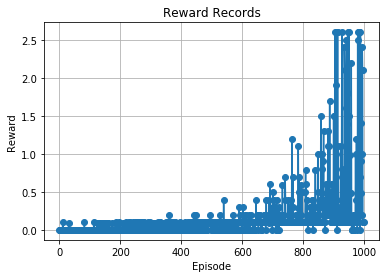

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(scores, 'o-')
plt.grid()
plt.title('Reward Records')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

The main issue with this implementation of the agent is its stability. Various tricks can be deployed to improve that, such as clipping of the gradients, prioritized experience replay(so that agent learns more from useful interactions). Learning from the raw pixels would also a great challenge, given that even the original problem is hard enough with high chances of divergence.